In [1]:
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
import mplhep as hep
import pandas as pd
hep.style.use(hep.style.CMS)
import hist as hist2

from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea.nanoevents.methods import candidate, vector
from coffea.analysis_tools import Weights, PackedSelection

# we suppress ROOT warnings where our input ROOT tree has duplicate branches - these are handled correctly.
import warnings
import uproot
from coffea import processor
import warnings 

warnings.filterwarnings('ignore')

In [2]:
#https://twiki.cern.ch/twiki/bin/viewauth/CMS/EgHLTRunIISummary
class triggerEffWbProcessor(processor.ProcessorABC):
    def __init__(self):
        self.make_output = lambda: {
            'sum': 0.,
            'pt_e_tr': hist2.Hist(
                hist2.axis.Regular(24, 30, 500, name='pt_e_tr'),
                ),
            'pt_e_tc': hist2.Hist(
                hist2.axis.Regular(24, 30, 500, name='pt_e_tc'),
                ),
            'eta_e_tr': hist2.Hist(
                hist2.axis.Regular(50, -2.4, 2.4, name='eta_e_tr'),
                ),
            'eta_e_tc': hist2.Hist(
                hist2.axis.Regular(50,-2.4, 2.4, name='eta_e_tc'),
                ),
            'met_tr': hist2.Hist(
                hist2.axis.Regular(30, 50, 500, name='met_tr'),
                ),
            'met_tc': hist2.Hist(
                hist2.axis.Regular(30, 50, 500, name='met_tc'),
                ),
            'pt_bjet_tr': hist2.Hist(
                hist2.axis.Regular(24, 30, 500, name='pt_bjet_tr'),
                ),
            'pt_bjet_tc': hist2.Hist(
                hist2.axis.Regular(24, 30, 500, name='pt_bjet_tc'),
                ),
            'eta_bjet_tr': hist2.Hist(
                hist2.axis.Regular(50, -2.1, 2.1, name='eta_bjet_tr'),
                ),
            'eta_bjet_tc': hist2.Hist(
                hist2.axis.Regular(50, -2.1, 2.1, name='eta_bjet_tc'),
                )
        }
    @property 
    def accumulator(self):
        return self._accumulator

    def process(self, events):
        dataset = events.metadata['dataset']
        #weights = Weights(len(events), storeIndividual=True)
        #weights.add('genweight', events.genWeight)
        
        selection = PackedSelection()
        
        output =self.make_output()
        
        output['sum'] = len(events)
        
        b_jet=events.Jet[events.Jet.btagDeepFlavB>0.4506]#[events.Jet.btagCSVV2>0.8484]
        events["bjet"]=b_jet
        
        #trigger
        
        trigger_de_ref=events.HLT.Ele23_Ele12_CaloIdL_TrackIdL_IsoVL

        trigger_central=events.HLT.Ele35_WPTight_Gsf
        
        ##electron
        
        events["heeplecton"]=events.Electron[events.Electron.cutBased_HEEP]
                       

        goodelectron = ((ak.sum(events.heeplecton.pt>0, axis=1)==2)
                        &((ak.pad_none(events.heeplecton.pt, 2)[:,0]>30) &(ak.pad_none(events.heeplecton.pt, 2)[:,1]>30))
                        &(((0<abs(ak.firsts(events.heeplecton.eta))) & (abs(ak.firsts(events.heeplecton.eta))<2.4))
                        & ((1.57<abs(ak.firsts(events.heeplecton.eta))) | (abs(ak.firsts(events.heeplecton.eta))<1.4)))
                #&((ak.pad_none(events.Electron.charge, 2)[:,0])!=(ak.pad_none(events.Electron.charge, 2)[:,1]))
                )

        #goodelectron = leading != subleading

        
        #b-jet
        
        goodbJets = ((ak.sum(events.bjet.pt>0, axis=1)==1)
            &(ak.firsts(events.bjet.pt)>30)
            &(abs(ak.firsts(events.bjet.eta))<2.1)
             )
        
        #met
        
        #goodMet=events.MET.pt>50
        
        #seleccion
        
        selection.add("trigger_de_ref",trigger_de_ref)
        selection.add("trigger_central",trigger_central)
        selection.add("electron",goodelectron)
        selection.add("bJet",goodbJets)
        #selection.add("Met",goodMet)
        
        #regions
        
        
        regions={"signal_trigger":["trigger_de_ref"],
         "signal_trigger_e":["trigger_de_ref","electron"],
         "signal_trigger_e_bjet":["trigger_de_ref","electron","bJet"],
         "signal_triggerref_e_bjet_met":["electron","bJet","trigger_de_ref"],
         "signal_triggerctl_e_bjet_met":["electron","bJet","trigger_de_ref","trigger_central"],
                }
        
        #candidates
        
        candidtae_events_ref=events[selection.all(*regions["signal_triggerref_e_bjet_met"])]
        candidtae_events_ctl=events[selection.all(*regions["signal_triggerctl_e_bjet_met"])]
        
        
            
        #selection out
        # pt e
        output['pt_e_tr'].fill(pt_e_tr = ak.firsts(candidtae_events_ref.heeplecton.pt))
        output['pt_e_tc'].fill(pt_e_tc = ak.firsts(candidtae_events_ctl.heeplecton.pt))
        
        #eta e
        output['eta_e_tr'].fill(eta_e_tr = ak.firsts(candidtae_events_ref.heeplecton.eta))
        output['eta_e_tc'].fill(eta_e_tc = ak.firsts(candidtae_events_ctl.heeplecton.eta))
        
        #Met
        output['met_tr'].fill(met_tr = candidtae_events_ref.MET.pt)
        output['met_tc'].fill(met_tc = candidtae_events_ctl.MET.pt)
        
        #pt bjet
        output['pt_bjet_tr'].fill(pt_bjet_tr = ak.firsts(candidtae_events_ref.bjet.pt))
        output['pt_bjet_tc'].fill(pt_bjet_tc = ak.firsts(candidtae_events_ctl.bjet.pt))
        
        #eta bjet
        
        output['eta_bjet_tr'].fill(eta_bjet_tr = ak.firsts(candidtae_events_ref.bjet.eta))
        output['eta_bjet_tc'].fill(eta_bjet_tc = ak.firsts(candidtae_events_ctl.bjet.eta))
        
        
        return {dataset: output}
            
    def postprocess(self, accumulator):
        return accumulator

In [3]:
import json
 
# Opening JSON file
f = open("./fileset/singleelectron.txt")
 
# returns JSON object as
# a dictionary
load_data = json.load(f)
datos=[]

#for i in range(50):
    #datos.append("root://xcache/"+load_data["SingleElectron"][i])

for i in load_data["SingleElectron"]:
    datos.append("root://xcache/"+i)

In [4]:
len(datos)

272

In [5]:
from dask.distributed import Client

client = Client("tls://arualesb-2e1-40cern-2ech.dask.coffea.casa:8786")
client

<Client: 'tls://192.168.176.207:8786' processes=1 threads=2, memory=7.00 GiB>

In [6]:
fileset={'TTT':datos}

In [7]:
out = processor.run_uproot_job(
    fileset,
    treename='Events',
    processor_instance=triggerEffWbProcessor(),
    executor=processor.dask_executor,
    executor_args={"schema": processor.NanoAODSchema, "client":client}#"workers": 4},
    #maxchunks=None,
)

In [8]:
out["TTT"]["sum"]
#106.978.000 en 2:59:03 min
#350.819.620 electrones
#769.081.942 muones

350819620

In [9]:
def get_value(den):
    return den.values()

def get_axis(den):
    return [den.axes.bin(i)[0][0] for i in range(len(den.values())+1)]

In [10]:
def graficar_hist(data,labels,namesave,xmin=0,xmax=600):
    plt.plot(igsize=(12, 4))
    hep.cms.lumitext("(13 TeV)")
    hep.cms.text("Work in Progress")
    hep.histplot(data.values(),bins=np.array(get_axis(data)),
                 color="black",density=True,label=labels)
    plt.xlim(xmin,xmax)
    plt.legend()
    plt.xlabel(labels)
    plt.savefig(namesave)

In [11]:
from hist.intervals import clopper_pearson_interval
def error(num, den):
    return abs(
        clopper_pearson_interval(num.values(), den.values()) - num.values() / den.values()
    )

def graf_eficience(num,den,labels,namesave,bar_error=False,ymin=0.8,ymax=1.03,xmin=0,xmax=600):
    hep.cms.lumitext("(13 TeV)")
    hep.cms.text("Work in Progress")
    eficience=np.array(num.values()/den.values())
    bines=np.array(get_axis(num))
    eficience[np.isnan(eficience)] = 0
    hep.histplot(eficience,bins=bines,label=labels)
    
    if bar_error:
        el_err = error(num, den)
        hep.histplot(eficience,bins=bines,yerr=el_err,histtype='errorbar',fmt="ko",
             capsize=3,label="error")    
    
    plt.ylim(ymin,ymax)
    plt.xlim(xmin,xmax)
    plt.legend()
    plt.xlabel(labels)
    plt.savefig(namesave)

In [12]:
pt_e_tr=out["TTT"]["pt_e_tr"]
pt_e_tc=out["TTT"]["pt_e_tc"]

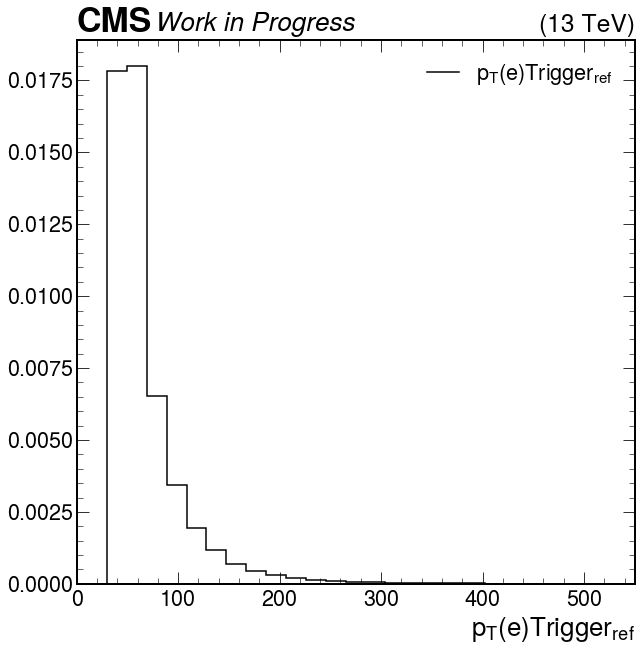

In [13]:
graficar_hist(pt_e_tr,labels="${p}_{T}(e) Trigger_{ref}$",
              namesave="./graf_11_02/pt_e_trigger_ref.jpg",
             xmin=0,xmax=550)

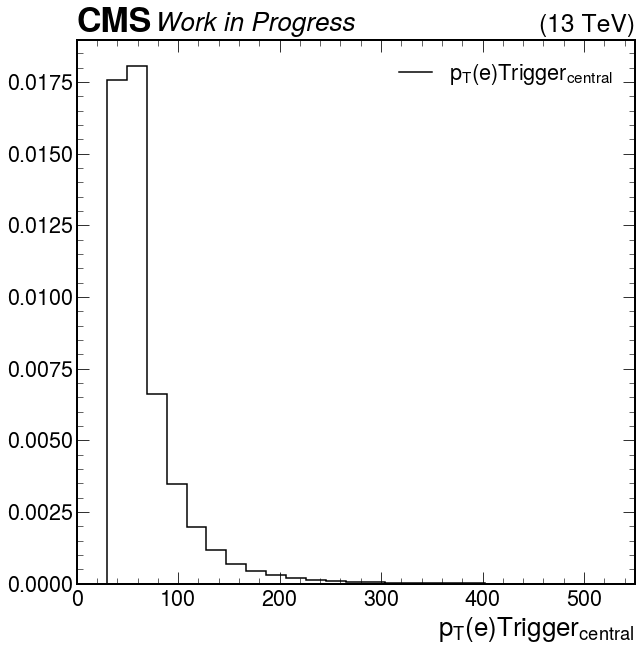

In [14]:
graficar_hist(pt_e_tc,labels="${p}_{T}(e) Trigger_{central}$",
              namesave="./graf_11_02/pt_e_trigger_ctl.jpg",
             xmin=0,xmax=550)

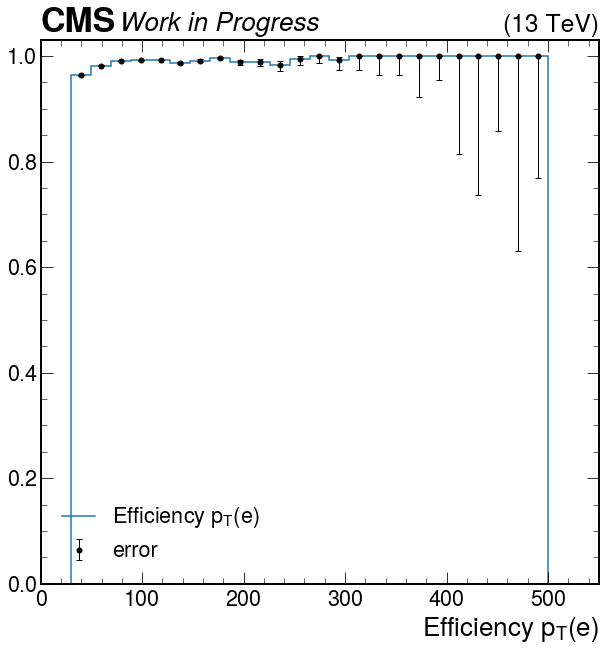

In [15]:
graf_eficience(pt_e_tc,pt_e_tr,bar_error=True,
               labels="Efficiency ${p}_{T}(e)$",
               namesave="./graf_04_03/Efficiency_pt_e.jpg",
              xmin=0,xmax=550,ymin=0)


#  $\eta (e)$

In [16]:
eta_e_tr=out["TTT"]["eta_e_tr"]
eta_e_tc=out["TTT"]["eta_e_tc"]

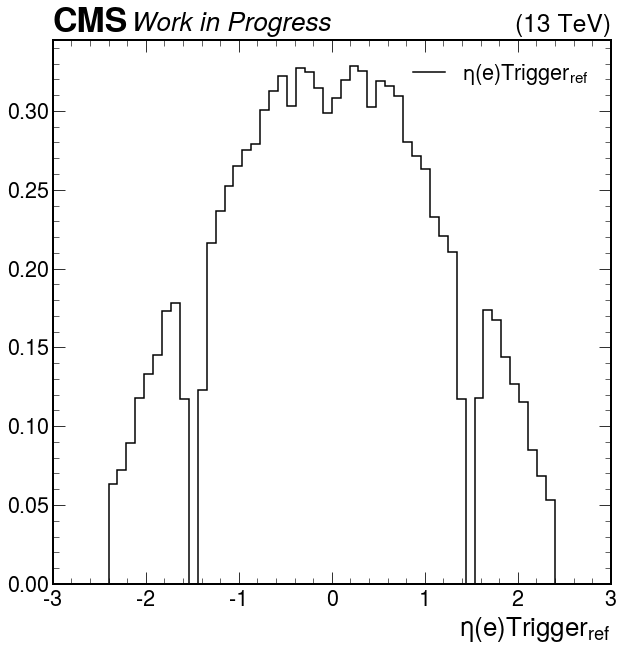

In [17]:
graficar_hist(eta_e_tr,labels="$\eta(e) Trigger_{ref}$",
              namesave="./graf_11_02/eta_e_trigger_ref.jpg",
             xmin=-3,xmax=3)

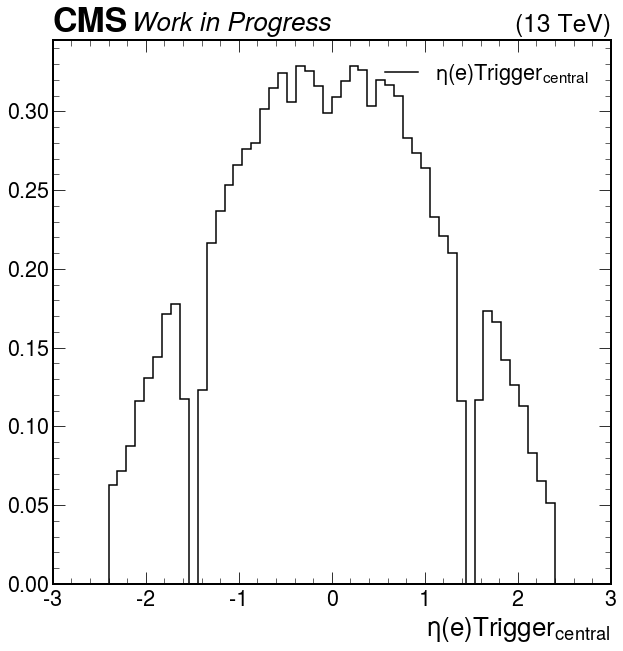

In [18]:
graficar_hist(eta_e_tc,labels="$\eta(e) Trigger_{central}$",
              namesave="./graf_11_02/eta_e_trigger_ctl.jpg",
             xmin=-3,xmax=3)

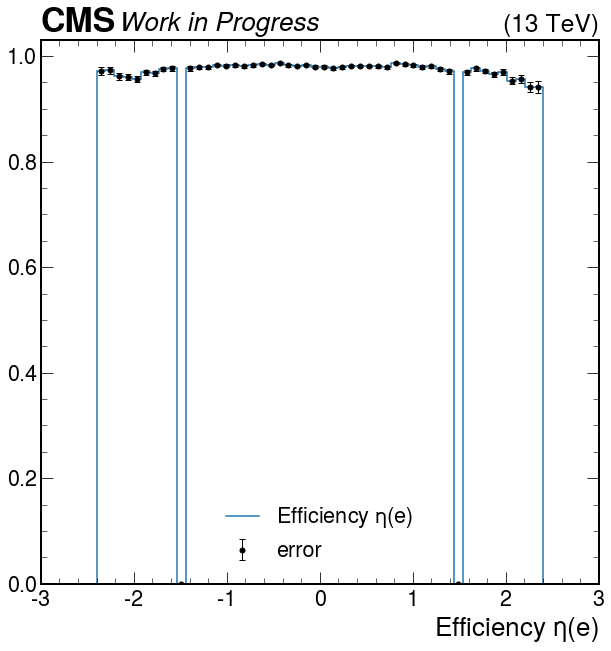

In [19]:
graf_eficience(eta_e_tc,eta_e_tr,bar_error=True,labels="Efficiency $\eta (e)$",
               namesave="./graf_04_03/Efficiency_eta_e.jpg",
              xmin=-3,xmax=3,ymin=0)

# MET

In [20]:
met_tr=out["TTT"]["met_tr"]
met_tc=out["TTT"]["met_tc"]

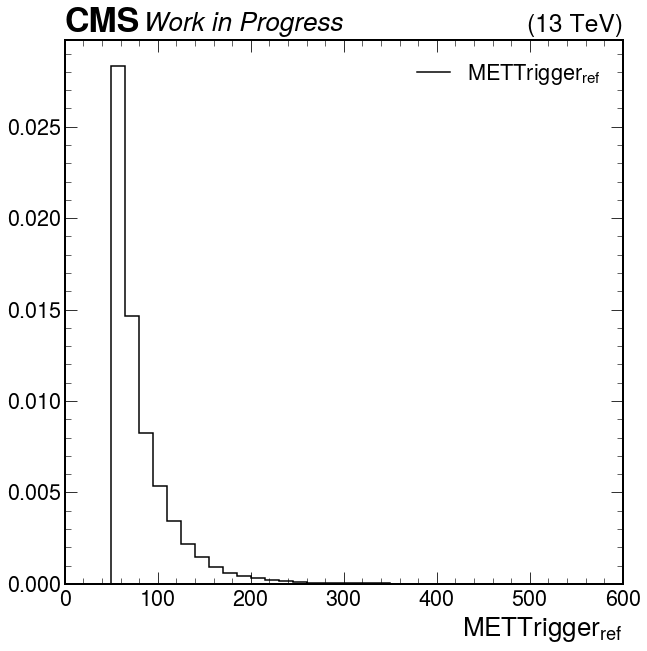

In [21]:
graficar_hist(met_tr,labels="$MET Trigger_{ref}$",
              namesave="./graf_11_02/met_trigger_ref.jpg",
             xmin=0,xmax=600)

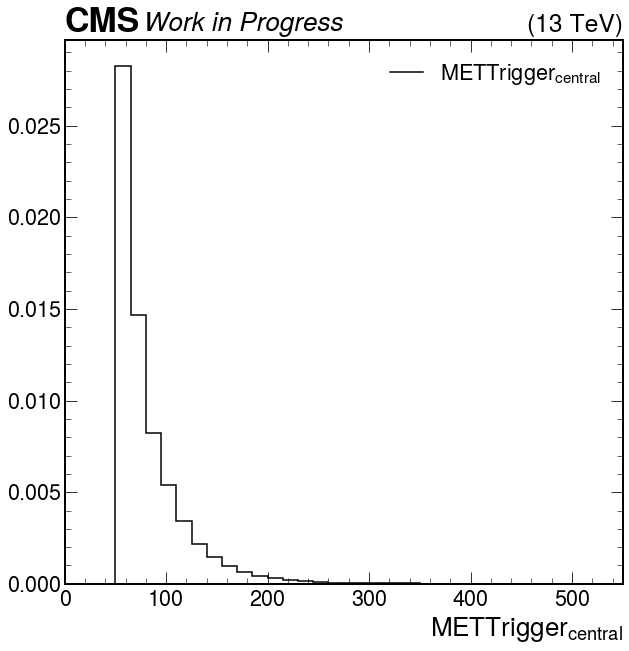

In [22]:
graficar_hist(met_tc,labels="$MET Trigger_{central}$",
              namesave="./graf_11_02/met_trigger_ctl.jpg",
             xmin=0,xmax=550)

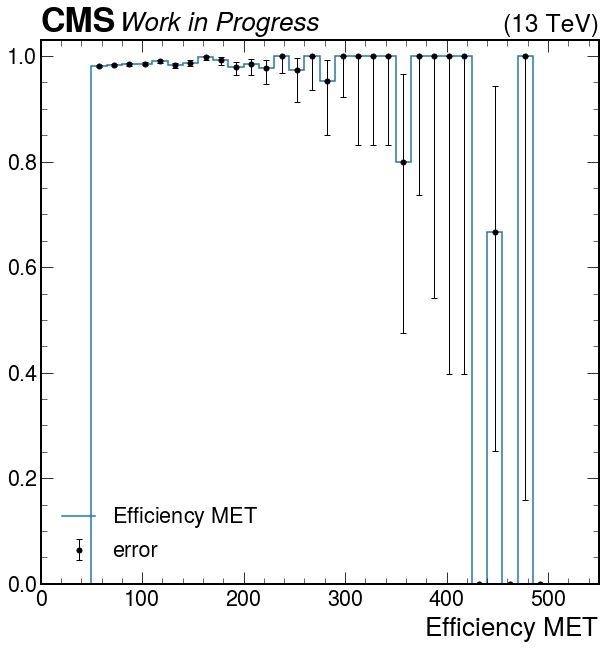

In [23]:
graf_eficience(met_tc,met_tr,bar_error=True,labels="Efficiency $MET$",
               namesave="./graf_11_02/Efficiency_met_e.jpg",
              xmin=0,xmax=550,ymin=0)

# $P_{T}$ b-jet

In [24]:
pt_bjet_tr=out["TTT"]["pt_bjet_tr"]
pt_bjet_tc=out["TTT"]["pt_bjet_tc"]

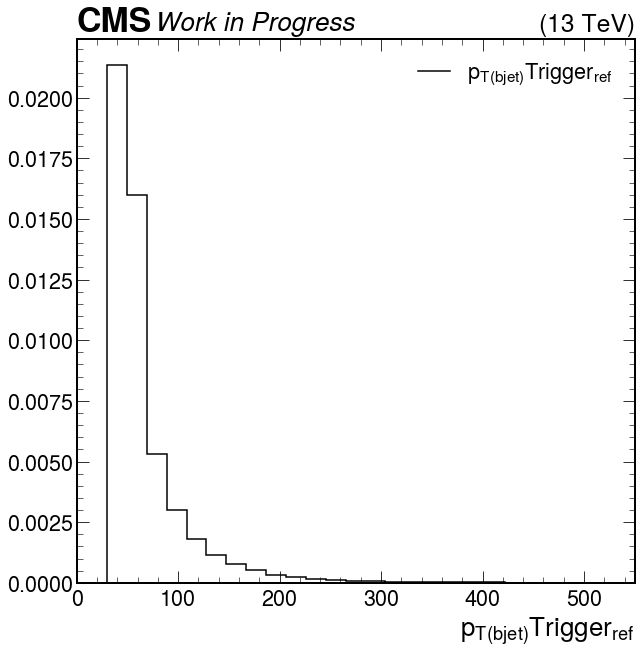

In [34]:
graficar_hist(pt_bjet_tr,labels="${{p}_{T}}_{(bjet)} Trigger_{ref}$",
              namesave="./graf_11_02/pt_bjet_trigger_ref.jpg",
             xmin=0,xmax=550)

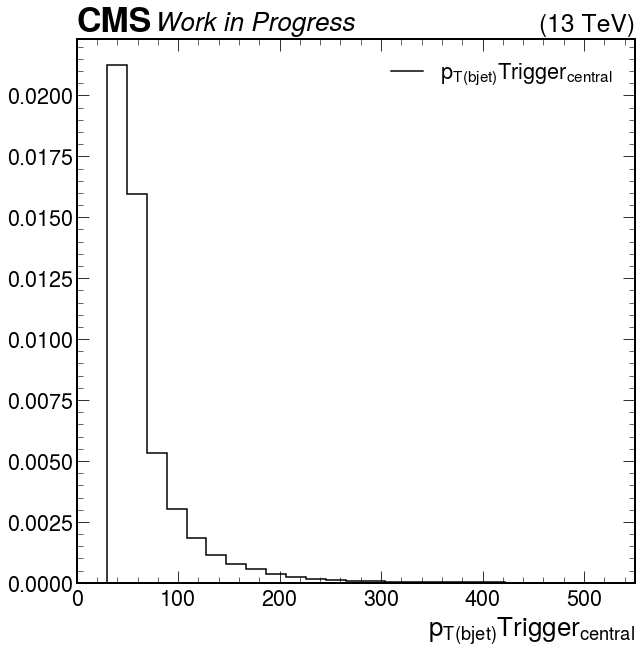

In [33]:
graficar_hist(pt_bjet_tc,labels="${{p}_{T}}_{(bjet)} Trigger_{central}$",
              namesave="./graf_11_02/pt_bjet_trigger_ctl.jpg",
             xmin=0,xmax=550)

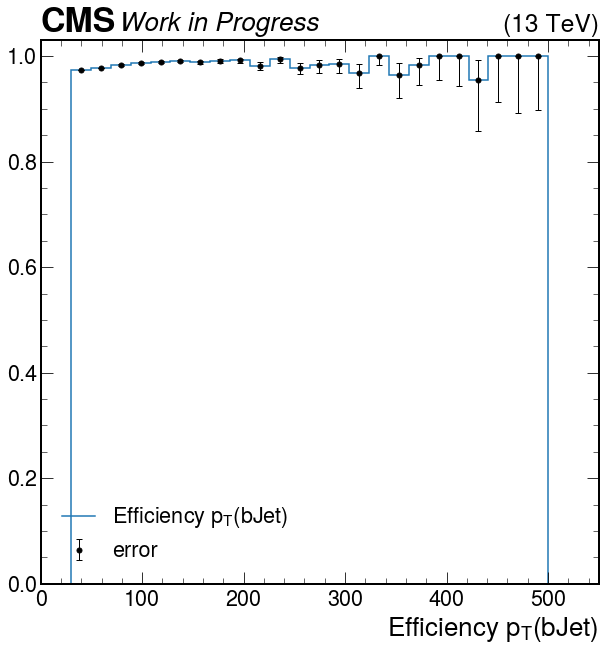

In [27]:
graf_eficience(pt_bjet_tc,pt_bjet_tr,bar_error=True,
               labels="Efficiency ${p}_{T}(bJet)$",
               namesave="./graf_04_03/Efficiency_pt_bjet.jpg",
              xmin=0,xmax=550,ymin=0)

# $\eta_{b-jet}$

In [28]:
eta_bjet_tr=out["TTT"]["eta_bjet_tr"]
eta_bjet_tc=out["TTT"]["eta_bjet_tc"]

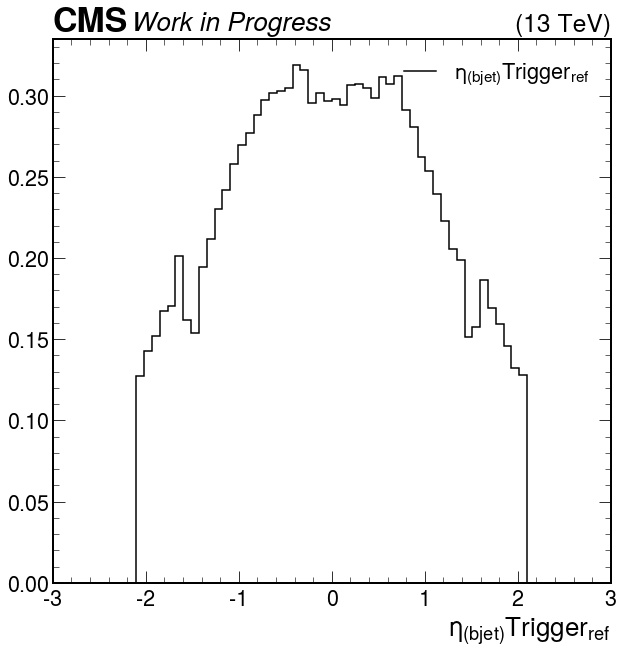

In [29]:
graficar_hist(eta_bjet_tr,labels="${\eta}_{(bjet)} Trigger_{ref}$",
              namesave="./graf_11_02/eta_bjet_trigger_ref.jpg",
             xmin=-3,xmax=3)

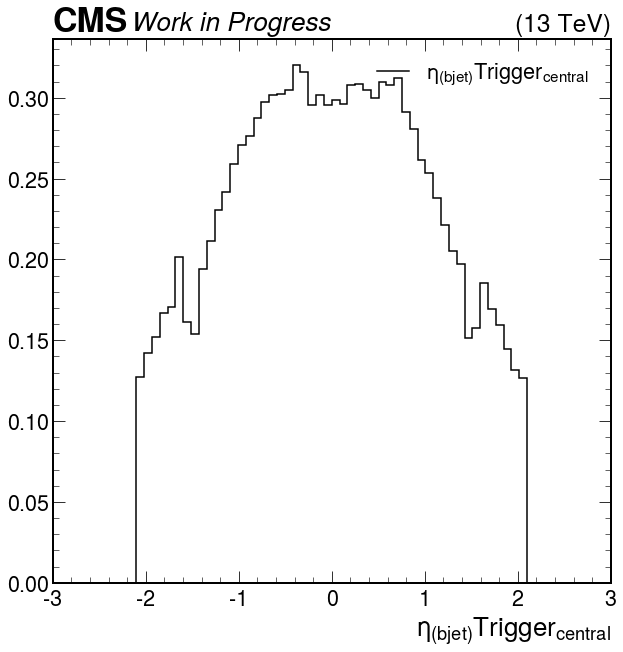

In [32]:
graficar_hist(eta_bjet_tc,labels="${\eta}_{(bjet)} Trigger_{central}$",
              namesave="./graf_11_02/eta_bjet_trigger_ctl.jpg",
             xmin=-3,xmax=3)

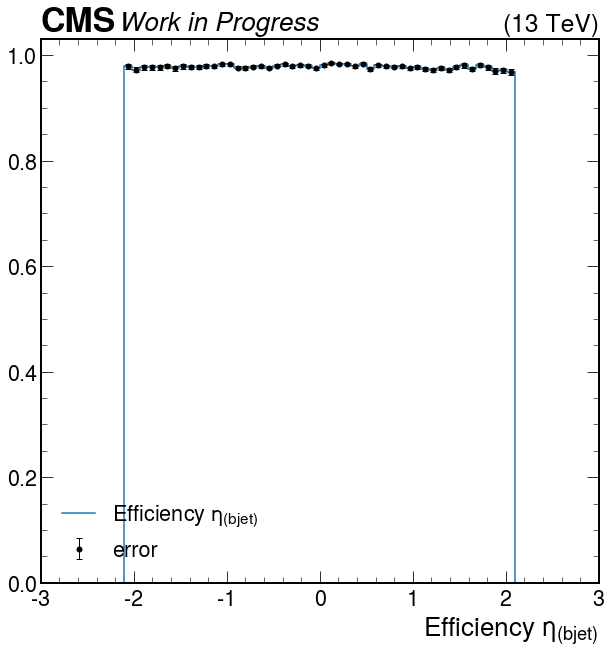

In [31]:
graf_eficience(eta_bjet_tc,eta_bjet_tr,bar_error=True,
               labels="Efficiency ${\eta}_{(bjet)}$",
               namesave="./graf_04_03/Efficiency_eta_bjet.jpg",
              xmin=-3,xmax=3,ymin=0)